# Morphing images
(Open 'warping_anim.gif' to see warping animation)

In [224]:
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import numpy as np
import os
import glob
from roipoly import RoiPoly
import cv2
from PIL import Image

In [289]:

x_vector = np.array([]) #33 files and 58 points per file (1914 total entries)
y_vector = np.array([]) #33 files and 58 points per file
files = []

i = 0
for filename in os.listdir('/home/pascal/computer_graphics/shape_interpolation_HW2/imm_face_db'):
    if filename.endswith("1m.asf") :  #all male faces (straight faces)
         x_s, y_s = get_landmarks(filename)
        #  print("file %d: %s" % (i,filename))
         files.append(filename)
         x_vector = np.append(x_vector, [[x_s]])
         y_vector = np.append(y_vector, [[y_s]])
         i = i+1
         continue
    else:
        continue

print("File num: %d" % len(files))
# print(len(files))
print('x pixel of 1st file: %f ' % x_vector[0]) # Manually compute this for check (27-1m.asf)
print('x_pixel of last file: %f' % x_vector[1913]) # (18-1m.asf)
print('Length of y vector: %d ' % y_vector.shape)


File num: 33
x pixel of 1st file: 231.992320 
x_pixel of last file: 321.790317
Length of y vector: 1914 


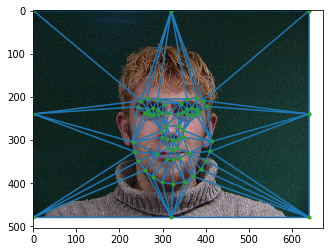

In [226]:

N_faces = 33
x_matrix = np.reshape(x_vector, (33, 58)) # now each image is a row in this matrix
y_matrix = np.reshape(y_vector, (33, 58))

s1 = np.zeros((58,2))
s2 = np.zeros((58, 2))
s1[:,0] = x_matrix[0]
s1[:,1] = y_matrix[0]

s2[:,0] = x_matrix[1]
s2[:,1] = y_matrix[1]

gen_warping_seq(s1, s2)

frames = []
imgs = glob.glob("./warping_results/*.jpg")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# print("Last new frame")
# print(new_frame)
# Save into a GIF file that loops forever
frames[0].save('./warping_results/warping_anim.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=300, loop=0)

avg_x_mtrx = np.array(np.sum(x_matrix, axis=0)/N_faces)
avg_y_mtrx = np.array(np.sum(y_matrix, axis=0)/N_faces)

avg_male = np.zeros((58,2))
avg_male[:,0] = avg_x_mtrx
avg_male[:,1] = avg_y_mtrx

avg_male = add_corners_and_edges(avg_male)
avg_male_tri = Delaunay(avg_male)
img = '/home/pascal/computer_graphics/shape_interpolation_HW2/imm_face_db/01-1m.jpg'
plot_delaunay(avg_male, avg_male_tri, img)



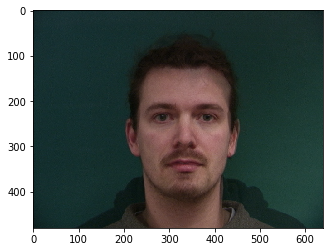

In [281]:

s1_file = "./imm_face_db/27-1m.jpg" #s1 is file 27-1m.jpg (That's just the order in which the files are read from the directory)
s2_file = "./imm_face_db/26-1m.jpg"
in_img = interpol_img(s1, s2, s1_file, s2_file, 0.5)
plt.imshow(in_img)
plt.show()

# Creating morph sequence


In [285]:
gen_morphing_anim(s1, s2, s1_file, s2_file)


Interplating face: 0.000000
Interplating face: 0.050000
Interplating face: 0.100000
Interplating face: 0.150000
Interplating face: 0.200000
Interplating face: 0.250000
Interplating face: 0.300000
Interplating face: 0.350000
Interplating face: 0.400000
Interplating face: 0.450000
Interplating face: 0.500000
Interplating face: 0.550000
Interplating face: 0.600000
Interplating face: 0.650000
Interplating face: 0.700000
Interplating face: 0.750000
Interplating face: 0.800000
Interplating face: 0.850000
Interplating face: 0.900000
Interplating face: 0.950000
Gif saved!


# Mean face of a population

In [290]:
def gen_avg_male(x_mtx, y_mtx, avg_male_s, avg_male_tri, files):

    final_img = np.zeros((480, 640, 3)) #hard coding is only for dev
    masked_img = np.zeros((480, 640, 3))
    N = len(files)
    
    for i in range(N):
        si[:,0] = x_mtx[i]
        si[:,1] = y_mtx[i]
        si = add_corners_and_edges(si)

        si_transf, si_transf_tri = transfer_tri(si, avg_male_tri) #copy triangulation of average male shape
        si_img = plt.imread("./imm_face_db/"+files[i])

        for j in range(avg_male_tri.simplices.shape[0]):
            Xij = si_transf[si_transf_tri.simplices[j]] # gets triangle an index j
            Xj_prime = avg_male[avg_male_tri.simplices[j]]

            Xij_cv2 = np.float32([Xij])
            Xj_prime_cv2 = np.float32([Xj_prime])

            aij = cv2.getAffineTransform(Xij_cv2, Xj_prime_cv2)

            sij_afn_img = cv2.warpAffine(si_img, aij, (640, 480))

            maskij = create_mask(sij_afn_img, Xj_prime)

            masked_imgij = cv2.bitwise_and(sij_afn_img, sij_afn_img, mask = maskij[:,:,0])

            masked_imgij = np.dot(masked_imgij, 1/N)

            masked_imgij += masked_imgij

            nz_i = np.where(masked_imgij[:,:0] > 0) #non zero indices of red channel
            final_img[nz_i] = masked_imgij[nz_i]

    final_img = final_img.astype(np.uint8)
    return final_img



In [283]:
def gen_morphing_anim(img1, img2, img1_file, img2_file):
    def my_range(sta, end, stp):
            while sta <= end:
                yield sta
                sta += stp

    frames = []
    for a in my_range(0, 1, 0.05):
        print("Interplating face: %f" % a)
        new_face = interpol_img(img1, img2, img1_file, img2_file, a)
        img_loc = "./morphing_results/morphing"+str(a)+".jpg"
        plt.imsave(img_loc, new_face)
        # img = glog.gob(file_loc)
        new_frame = Image.open(img_loc)
        frames.append(new_frame)
            
#     imgs = glob.glob("*.jpg")
# for i in imgs:
#     new_frame = Image.open(i)
#     frames.append(new_frame)
    frames[0].save('./morphing_results/morphing_anim.gif', format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=500, loop=0)

    print("Gif saved!")

In [278]:
def interpol_img(img1, img2, img1_file, img2_file, a):
    # print("Interpolating new face")
    img1 = add_corners_and_edges(img1)
    img2 = add_corners_and_edges(img2)
    in_pts, in_tri = interpl_shape(img1, img2, a) #interpolates in between shape that is 50% between img1 and img2
    # plot_shape_tri(in_pts, in_tri)

    
    img1_transf, img1_transf_tri = transfer_tri(img1, in_tri) #Transfer edges for average shape to shape img1
    # plot_shape_tri(img1_transf, img1_transf_tri)

   
    img2_transf, img2_transf_tri = transfer_tri(img2, in_tri) #Transfer edges for average shape to shape img2
    # plot_shape_tri(img2_transf, img2_transf_tri)

    # print(img2_transf_tri.simplices.shape)
    # print(img1_transf_tri.simplices.shape)
    # print(img1_transf[img1_transf_tri.simplices[0]])
    # print("Number of simplices:")
    # for i in range(in_tri.simplices.shape[0]):
    final_img = np.zeros((480, 640, 3)) #hard coding is only for dev
    masked_img = np.zeros((480, 640, 3))

    img1_img = plt.imread(img1_file)
    img2_img = plt.imread(img2_file)

    # plt.imshow(img1_img)
    # plt.show()

    # plt.imshow(img2_img)
    # plt.show()

    for i in range(in_tri.simplices.shape[0]):
    # for i in range(5):
        X1 = img1_transf[img1_transf_tri.simplices[i]] #img1 triangle
        X2 = img2_transf[img2_transf_tri.simplices[i]] #img1 triangle
        X_prime = in_pts[in_tri.simplices[i]] #img1 triangle

        X1_cv2 = np.float32([X1])
        X2_cv2 = np.float32([X2])
        X_prime_cv2 = np.float32([X_prime])
        # print("X1_cv2")
        # print(X1_cv2)

        a1 = cv2.getAffineTransform(X1_cv2, X_prime_cv2)
        a2 = cv2.getAffineTransform(X2_cv2, X_prime_cv2)

        rows, cols, ch = img1_img.shape
        # print("img1 shape: %s" % str(img1_img.shape))
        img1_afn_img = cv2.warpAffine(img1_img, a1,(cols, rows))
        img2_afn_img = cv2.warpAffine(img2_img, a2,(cols, rows))

        mask1 = create_mask(img1_afn_img, X_prime)
        mask2 = create_mask(img2_afn_img, X_prime)
        # plt.imshow(mask1)
        # plt.show()

        masked_img1 = cv2.bitwise_and(img1_afn_img,img1_afn_img,mask = mask1[:,:,0])
        masked_img2 = cv2.bitwise_and(img2_afn_img,img2_afn_img,mask = mask2[:,:,0])

        masked_img1 = np.dot(masked_img1, (1-a))
        masked_img2 = np.dot(masked_img2, a)

        masked_img = masked_img1+masked_img2
        masked_img = masked_img.astype(np.uint8)

        nz_i = np.where(masked_img[:,:,0] > 0) #non zero indices of red channel
        final_img[nz_i] = masked_img[nz_i]
        # plt.imshow(final_img)
        # plt.show()
        # final_img += masked_img
        # final_img =  np.add(final_img,masked_img)
    # plt.show()
    final_img = final_img.astype(np.uint8)
    # plt.imshow(final_img)
    return final_img




In [ ]:
# def create_3d_mask(mask_2d):
#     mask_3d = np.zeros((mask_2d.shape[0], mask_2d.shape[1], 3))

#     mask_3d[:,:,0] = mask_2d
#     mask_3d[:,:,1] = mask_2d
#     mask_3d[:,:,2] = mask_2d

#     return mask_3d

In [ ]:
def create_mask(img, roi):
    mask = np.zeros(img.shape[:2], dtype = 'uint8')
    mask = mask.astype(np.uint8)

    mask_img = cv2.drawContours(mask,[roi.astype(int)],0,255,-1) #casting roi to int might lose some precision
    mask_img = cv2.cvtColor(mask_img,cv2.COLOR_GRAY2BGR)

    return mask_img

In [ ]:
def interpl_shape(start, end, a):
    in_s = (1-a)*start + a*end #interpolated shape
    # print(start[0])
    # print(end[0])
    # print(in_s[0])
    in_s_tri = Delaunay(in_s)

    return in_s, in_s_tri


In [ ]:
def inverseMapping(A, X, X_prime, img) :
    #n_rows, n_cols = getDstImageSize(X_prime) #Compute minimum size of destination image from destination triangle 
    #The line above is prescribed in the algorithm but it does not work
    #If the image is displayed using n_rows and n_cols computed above it will be cropped
    srcImgRows = img.shape[0] # Instead use dimesions of src image to display dst image
    srcImgCols = img.shape[1]
    dstImg = np.zeros((srcImgRows, srcImgCols, 3)) #Destination image should be computed using srcImg dimensions
    # print('Dest image shape: ')
    # print(dstImg.shape)
    # print('Inverse of transformation matrix: ')
    A_inv = np.linalg.inv(A)
    # print(A_inv)
    # print(img.shape)
    # outputHmg = open('outputHmg.txt', 'w')
    # outputMtrx = open('outputMtrx.txt', 'w')
    # print(srcImgRows)
    # print(srcImgCols)
   
    for i in range(0, srcImgRows) :
        for j in range(0, srcImgCols):
            #On 2nd interation, u=1 and v = 0 of position (1,0) on image
            x,y = inverseTransformation(j,i,A_inv) # put j 1'st because we want to map matrix pos 0,1 to image pixel 1,0
            if isWithinBoundaries(x, y, srcImgCols, srcImgRows):
                dstImg[i, j, 0] = img[x, y, 0] #Copy x first, not y, these pixels are still stored in a matrix 
                dstImg[i, j, 1] = img[x, y, 1] #The reason copying y first works in example is because the image is a perfect square so it makes no difference
                dstImg[i, j, 2] = img[x, y, 2]
    # outputHmg.close()
    dstImg = 255 - dstImg # I am not entirely sure why I have to do this, but if I don't it will paint the negative of the transormed image
    # verifyDstImg(dstImg, img)
    return dstImg

In [ ]:
def inverseTransformation(u,v,A_inv):
    dstMatrx = np.array([[v], 
                         [u], 
                         [1]
                        ])
    srcHmgMtrx = np.dot(A_inv, dstMatrx) #This matrix will be homogeneous
    srcMtrx = np.array([srcHmgMtrx[0][0], srcHmgMtrx[1][0]]) # get rid of the 1 and make it 2d vector
    x = int(srcMtrx[0])
    y = int(srcMtrx[1])
    return x,y

In [ ]:
def isWithinBoundaries(x, y, nCols, nRows):
    # Return True if (x,y) is within the boundaries of matrix sourceImage(nRows,nCols)
    return (x>=0 and x<nRows and y >= 0 and y < nCols) #CompAring x to rows not cols because x in image from increments in y direction (reverse in matrix form)

In [ ]:
def estimateAffine(X, X_prime) :
    M = np.array([
                [X[0][0], X[0][1], 1, 0, 0, 0], 
                [0, 0, 0, X[0][0], X[0][1], 1],
                [X[1][0], X[1][1], 1, 0, 0, 0],
                [0, 0, 0, X[1][0], X[1][1], 1],
                [X[2][0], X[2][1], 1, 0, 0, 0],
                [0, 0, 0, X[2][0], X[2][1], 1]
                ]) #Source matrix represneted with 3 points homogenously (eq.7)
  
    b = np.array([[X_prime[0][0]], 
                 [X_prime[0][1]], 
                 [X_prime[1][0]], 
                 [X_prime[1][1]], 
                 [X_prime[2][0]], 
                 [X_prime[2][1]]]) #Destination matrix as a column vector
    # print(M)
    # print(b)
    M_inv = np.linalg.inv(M) #Computer inverse of M matrix
    M_id = np.dot(M, M_inv) #M identity matrix
    # print(M_id) #Verifying that I get an identity matrix
    I = np.identity(6)
    # print(np.identity(6))
    a = np.dot(M_inv, b) #Compute transformation coefficients
    # print("Transformation coefficients: ")
    # print(a)
    a = homogenize3(a)
    return a

In [ ]:
def homogenize3(m) : 
    hom = np.array([
                   [m[0][0], m[1][0], m[2][0]],
                   [m[3][0], m[4][0], m[5][0]],
                   [0, 0, 1]
                   ])
    return hom 

In [ ]:
def plot_shape_tri(s, s_tri):
    plt.triplot(s[:,0], s[:,1], s_tri.simplices.copy())
    plt.plot(s[:,0], s[:,1],'.')
    plt.show()


In [268]:
def transfer_tri(pts1, pts2_tri):
    pts1_t = pts1 #target for transfer, we firt copy all the points in the target (_t is for transfer)

    pts1_tri = Delaunay(pts1)
    # From transfer tri
   
    pts1_t_tri = Delaunay(pts1_t)

    pts1_t_tri.simplices = pts2_tri.simplices #copy edges from the second triangulation 
    
    return pts1_t, pts1_t_tri


In [ ]:
def gen_warping_seq(s1, s2):
    def my_range(sta, end, stp):
        while sta <= end:
            yield sta
            sta += stp

    for a in my_range(0, 1, 0.1):
        sj = (1-a)*s1 + a*s2
        delaunay_tri = Delaunay(sj)  
        plt.triplot(sj[:,0], sj[:,1], delaunay_tri.simplices.copy())
        plt.plot(sj[:,0], sj[:,1],'.')

        plt.gca().invert_yaxis() #Flip the print

        plt.savefig('./warping_results/warping_'+str(a)+'.jpg')
        plt.clf() #clear plt


In [ ]:
def plot_delaunay(points, tri, img) :
    img = plt.imread(img)
    imgplot = plt.imshow(img)
    plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
    plt.plot(points[:,0], points[:,1],'.')
    plt.show()

In [257]:
def add_corners_and_edges(pts):
    points = np.append(pts, [[0,0], [0,480], [640,0],[640,480],[0,480/2], [640, 480/2], [640/2, 0],[640/2, 480]], axis=0)
    return points

In [ ]:
def get_landmarks(filename):
    TOTAL_POINTS = 58
    x_s = np.zeros((0,1))
    y_s = np.zeros((0,1))
    landmark_file = open("./imm_face_db/"+ filename, "r")

    for i in range(80):
        line = landmark_file.readline()
        if (i >= 16) & (i <= 16 + (TOTAL_POINTS-1)) : #landmark indices start at on line 16
            line_16 = line
            splitted_line = line_16.split("\t", 4)
            x = splitted_line[2]
            y = splitted_line[3]
            x_pixel = float(x)*640 #Multiply by image width (Why isn't this returning an integer?)
            y_pixel = float(y)*480 #Multiply by image heighh
            x_s = np.append(x_s, [[x_pixel]])
            y_s = np.append(y_s, [[y_pixel]])
  
    landmark_file.close()
    return x_s, y_s